In [ ]:
from torch.utils.tensorboard import SummaryWriter
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import datetime
import torch.backends.cudnn as cudnn
import shutil

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
latent_size = 100 # latent_size
hidden_g = 64 # The number of hidden node of generator
hidden_d = 64 # The number of hidden node of discriminator

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is (batch, latent_size, 1, 1)
            nn.ConvTranspose2d(latent_size, hidden_g * 8, 4, 1, 0, bias=False), # (batch, latent_size, 1, 1) => (batch, 512, 4, 4)
            nn.BatchNorm2d(hidden_g * 8),
            nn.ReLU(False),
            nn.ConvTranspose2d(hidden_g * 8, hidden_g * 4, 4, 2, 1, bias=False), # (batch, 512, 4, 4) => (batch, 256, 8, 8)
            nn.BatchNorm2d(hidden_g * 4),
            nn.ReLU(False),
            nn.ConvTranspose2d(hidden_g * 4, hidden_g * 2, 4, 2, 1, bias=False), # (batch, 256, 8, 8) => (batch, 128, 16, 16)
            nn.BatchNorm2d(hidden_g * 2),
            nn.ReLU(False),
            nn.ConvTranspose2d(hidden_g * 2, hidden_g, 4, 2, 1, bias=False), # (batch, 128, 16, 16) => (batch, 64, 32, 32)
            nn.BatchNorm2d(hidden_g),
            nn.ReLU(False),
            nn.ConvTranspose2d(hidden_g,      1, 4, 2, 1, bias=False), # (batch, 64, 32, 32) => (batch, 1, 64, 64)
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output


netG = Generator().to(device)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (batch, 1, 64, 64)
            nn.Conv2d(1, hidden_d, 4, 2, 1, bias=False), # (batch, 1, 64, 64) => (batch, 64, 32, 32)
            nn.LeakyReLU(0.2, inplace=False),
            nn.Conv2d(hidden_d, hidden_d * 2, 4, 2, 1, bias=False), # (batch, 64, 32, 32) => (batch, 128, 16, 16)
            nn.BatchNorm2d(hidden_d * 2),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Conv2d(hidden_d * 2, hidden_d * 4, 4, 2, 1, bias=False), # (batch, 128, 16, 16) => (batch, 256, 8, 8)
            nn.BatchNorm2d(hidden_d * 4),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Conv2d(hidden_d * 4, hidden_d * 8, 4, 2, 1, bias=False), # (batch, 256, 8, 8) => (batch, 512, 4, 4)
            nn.BatchNorm2d(hidden_d * 8),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Conv2d(hidden_d * 8, 1, 4, 1, 0, bias=False), # (batch, 512, 4, 4) => (batch, 1, 1, 1)
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


netD = Discriminator().to(device)

In [ ]:
netG.load_state_dict(torch.load('/content/drive/MyDrive/DCGAN_Result/2021-03-25-18:07/weights/netG_epoch_25.pth'))
netD.load_state_dict(torch.load('/content/drive/MyDrive/DCGAN_Result/2021-03-25-18:07/weights/netD_epoch_25.pth'))

<All keys matched successfully>

In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach(), nrow = 10)
    img = (img + 1) / 2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()

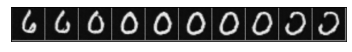

In [ ]:
n_sample = 2

# generate points in the latent space
x_input = np.random.randn(latent_size * n_sample)
# reshape into a batch of inputs for the network
z_input = x_input.reshape(n_sample, latent_size)


def interpolate_points(p1, p2, n_steps = 10):
    ratios = np.linspace(0, 1, num = n_steps)
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

# z_input[0] => (1, 100)
interpolated = interpolate_points(z_input[0], z_input[1]) # (10 ,100)

torch_z = torch.Tensor(interpolated)

inter_result = netG(torch_z.view(10, 100, 1, 1).to(device))

imshow_grid(inter_result)



In [ ]:
print(inter_result.shape)

torch.Size([10, 1, 64, 64])


In [ ]:
torchvision.utils.save_image(inter_result, "latent2.png", normalize = True, nrow = 10)